In [1]:
import numpy as np
import pandas as pd
import sys
import os
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px

# Setup paths
src_path = os.path.abspath(os.path.join('..'))
sys.path.append(src_path)
from utilities import clean_data
data_folder = os.path.join(src_path, 'data')

# Load and clean data
df = pd.read_csv(f'{data_folder}/MMR_DATA.csv')
df = clean_data(df)

In [2]:
# Load USE model and generate embeddings
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
print("Model loaded")
X = df['Map Data'].to_numpy()
embeddings_list = embed(X.tolist()).numpy()
print("Embeddings generated")
df_embeddings = pd.DataFrame(embeddings_list)

# Create final dataset
df_final = pd.concat([df, df_embeddings], axis=1)
# df_final.to_csv(f'{data_folder}/MMR_DATA_USE_EMBEDDINGS.csv', index=False)
# df_embeddings.to_csv(f'{data_folder}/MMR_DATA_USE_EMBEDDINGS_ONLY.csv', index=False)

# Clustering
df_embeddings_np = df_embeddings.to_numpy()
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(df_embeddings_np)

Model loaded
Embeddings generated


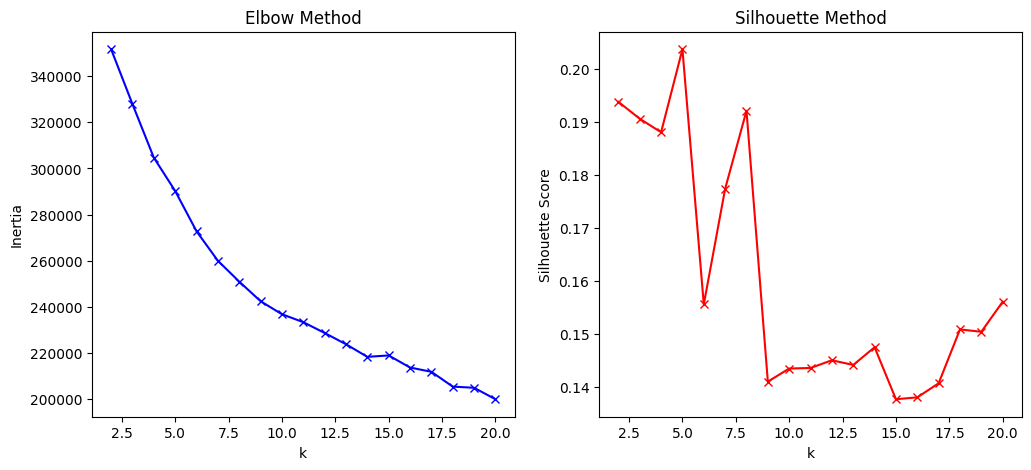

In [9]:
# Find optimal k using elbow method
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouette_scores = []
K = range(2, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_embeddings, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()


# # Auto-labeling function
# def autogenerate_labels(df):
#     map_data = df['Map Data'].to_numpy()
#     embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
#     embeddings_list = embed(map_data.tolist()).numpy()
    
#     scaler = StandardScaler()
#     scaled_embeddings = scaler.fit_transform(embeddings_list)
    
#     n_clusters = 4
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(scaled_embeddings)
    
#     df['label'] = kmeans.labels_ + 1
#     return df

# # Test auto-labeling
# df = pd.read_csv(f'{data_folder}/MMR_DATA.csv')
# df = clean_data(df)
# df = autogenerate_labels(df)

In [10]:
# Choose optimal k from elbow point
from kneed import KneeLocator
kn = KneeLocator(K, inertias, curve='convex', direction='decreasing')
optimal_k = kn.knee
print(f'Optimal k: {optimal_k}')
# Use optimal k for clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_embeddings)
y_kmeans = kmeans.labels_

# TSNE visualization
strings = df_final['Map Data'].to_numpy()
tsne = TSNE(n_components=3, random_state=0, verbose=2, perplexity=25, n_iter=4000)
x_3d = tsne.fit_transform(scaled_embeddings)

df = pd.DataFrame({
    'x': x_3d[:, 0],
    'y': x_3d[:, 1],
    'z': x_3d[:, 2],
    'label': y_kmeans[:x_3d.shape[0]] + 1,
    'strings': strings[:x_3d.shape[0]]
})

# Plot
color_sequence = px.colors.qualitative.Plotly
fig = px.scatter_3d(df, x='x', y='y', z='z', 
                    color='label', 
                    color_discrete_sequence=color_sequence,
                    hover_data={'strings': True})
fig.show()

Optimal k: 9
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 814 samples in 0.001s...
[t-SNE] Computed neighbors for 814 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 814 / 814
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 65.3392639, gradient norm = 0.0117276 (50 iterations in 0.249s)
[t-SNE] Iteration 100: error = 64.6548691, gradient norm = 0.0002459 (50 iterations in 0.177s)
[t-SNE] Iteration 150: error = 64.6499939, gradient norm = 0.0001394 (50 iterations in 0.189s)
[t-SNE] Iteration 200: error = 64.6498108, gradient norm = 0.0001057 (50 iterations in 0.180s)
[t-SNE] Iteration 250: error = 64.6509399, gradient norm = 0.0001069 (50 iterations in 0.193s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.650940
[t-SNE] Iteration 300: error = 0.8536908, gradient norm = 0.0095617 (50 iterations in 0.193s)
[t-SNE] Iteration 350: error = 0.6572074, gradient norm 